In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TL;DR Diffusion Model

- If we add steady amount of Gaussian noise repeated, eventually it will be corrupted into indistinguishable from a random Gaussian Sample
- Diffusion model learns to reverse the procedure

# Predicting original image


This is doing diffusion the "wrong" way by having the model predict the original image $x_0$. I implemented it as this is the most intuitive and I want to compare it with predicting the noise.

In [4]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class BasicDiffusion:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

        # Compute alpha_cumprod_prev and posterior_variance
        self.alpha_cumprod_prev = torch.cat(
            [torch.ones(1, device=device), self.alpha_cumprod[:-1]]
        )
        self.posterior_variance = (
            (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        ) * self.betas
        self.device = device
        self.model = model

    # q(xt|x0)
    def q(self, x_0, t):
        alpha_cumprod_t = gather(self.alpha_cumprod, t)
        mean = torch.sqrt(alpha_cumprod_t) * x_0
        var = 1.0 - alpha_cumprod_t
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    # p(x_t-1|x_t)
    def p_sample(self, x_t, t):
        x0_pred = self.model(x_t, t)

        alpha_bar_t = gather(self.alpha_cumprod, t)
        alpha_bar_prev_t = gather(self.alpha_cumprod_prev, t)
        alpha_t = gather(self.alpha, t)
        beta_t = gather(self.betas, t)

        mu_coef_x0 = (alpha_bar_prev_t.sqrt() * beta_t) / (1 - alpha_bar_t)
        mu_coef_xt = ((1 - alpha_bar_prev_t) * (1 - beta_t).sqrt()) / (1 - alpha_bar_t)
        # mu_coef_xt = (alpha_t.sqrt() * (1 - alpha_bar_prev_t)) / (1 - alpha_bar_t)

        mean = mu_coef_x0 * x0_pred + mu_coef_xt * x_t

        var = gather(self.posterior_variance, t)
        noise = torch.randn_like(x_t)
        mask = (t > 0).float()[:, None, None, None]
        x_t_prev = mean + torch.sqrt(var) * noise * mask

        return x_t_prev

    def loss(self, x0, noise=None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device).long()
        if noise is None:
            noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        x0_pred = self.model(x_t, t)
        return F.mse_loss(x0_pred, x0)

    def forward(self, x0, noise=None):
        return self.loss(x0, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

### Simple UNet implementaion for sanity check

In [5]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)

        attn = torch.bmm(q, k) * (C**-0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Downsampling
        self.down1 = nn.ModuleList(
            [
                ResidualBlock(in_channels, base_channels, time_dim, groups=1),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )
        self.down2 = nn.ModuleList(
            [
                ResidualBlock(base_channels, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels * 2, time_dim),
            ]
        )

        # Middle
        self.mid = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels * 4, time_dim),
                SelfAttentionBlock(base_channels * 4),
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
            ]
        )

        # Upsampling
        self.up2 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels, time_dim),
            ]
        )
        self.up1 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels, time_dim),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []

        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14

        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7

        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)

        return self.final_conv(x)


# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)

In [6]:
model = UNet().to(device)
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

1009635


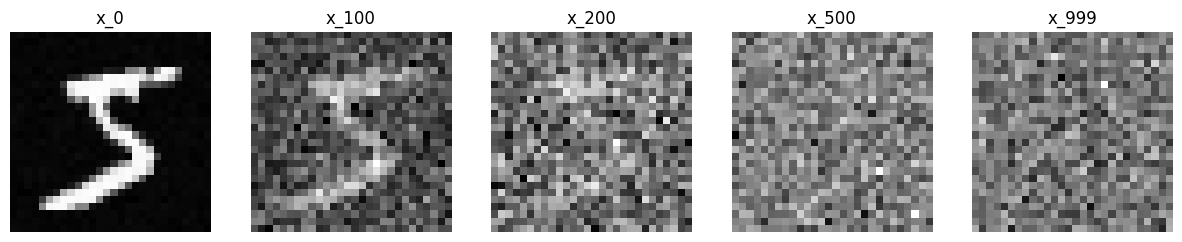

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

os.makedirs("checkpoints", exist_ok=True)
# os.makedirs("samples", exist_ok=True)

config = {
    "batch_size": 1280,
    "epochs": 200,
    "lr": 1e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data augmentation
transform = transforms.Compose(
    [
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Initialization
model = UNet().to(device)
diffusion = BasicDiffusion(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
train_dataset = torchvision.datasets.MNIST(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
sampled_image = dataloader.dataset.data[:1].unsqueeze(1).float() / 255.0

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    sampled_image = diffusion.q_sample(
        sampled_image.unsqueeze(0).to(device), t=torch.tensor([t]).to(device)
    )
    sampled_images.append(sampled_image.squeeze().cpu())

# Plot the sampled images
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 526kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.05MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.11MB/s]
Epoch 1/200: 100%|██████████| 47/47 [00:06<00:00,  6.90it/s, Loss=0.1882]


Epoch 1 | Avg Loss: 0.2497


Epoch 2/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1734]


Epoch 2 | Avg Loss: 0.1786


Epoch 3/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1726]


Epoch 3 | Avg Loss: 0.1715


Epoch 4/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1631]


Epoch 4 | Avg Loss: 0.1672


Epoch 5/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1637]


Epoch 5 | Avg Loss: 0.1653


Epoch 6/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1620]


Epoch 6 | Avg Loss: 0.1622


Epoch 7/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1640]


Epoch 7 | Avg Loss: 0.1619


Epoch 8/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1680]


Epoch 8 | Avg Loss: 0.1601


Epoch 9/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1586]


Epoch 9 | Avg Loss: 0.1596


Epoch 10/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1548]


Epoch 10 | Avg Loss: 0.1584


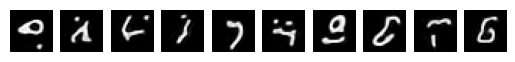

Epoch 11/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1598]


Epoch 11 | Avg Loss: 0.1571


Epoch 12/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1544]


Epoch 12 | Avg Loss: 0.1574


Epoch 13/200: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1534]


Epoch 13 | Avg Loss: 0.1562


Epoch 14/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1523]


Epoch 14 | Avg Loss: 0.1556


Epoch 15/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1516]


Epoch 15 | Avg Loss: 0.1563


Epoch 16/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1570]


Epoch 16 | Avg Loss: 0.1549


Epoch 17/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1580]


Epoch 17 | Avg Loss: 0.1549


Epoch 18/200: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1518]


Epoch 18 | Avg Loss: 0.1554


Epoch 19/200: 100%|██████████| 47/47 [00:06<00:00,  7.26it/s, Loss=0.1525]


Epoch 19 | Avg Loss: 0.1543


Epoch 20/200: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1444]


Epoch 20 | Avg Loss: 0.1539


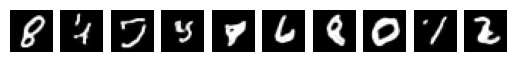

Epoch 21/200: 100%|██████████| 47/47 [00:06<00:00,  7.27it/s, Loss=0.1555]


Epoch 21 | Avg Loss: 0.1537


Epoch 22/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1552]


Epoch 22 | Avg Loss: 0.1534


Epoch 23/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1522]


Epoch 23 | Avg Loss: 0.1526


Epoch 24/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1560]


Epoch 24 | Avg Loss: 0.1523


Epoch 25/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1554]


Epoch 25 | Avg Loss: 0.1524


Epoch 26/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1491]


Epoch 26 | Avg Loss: 0.1526


Epoch 27/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1500]


Epoch 27 | Avg Loss: 0.1528


Epoch 28/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1570]


Epoch 28 | Avg Loss: 0.1522


Epoch 29/200: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1510]


Epoch 29 | Avg Loss: 0.1515


Epoch 30/200: 100%|██████████| 47/47 [00:06<00:00,  7.25it/s, Loss=0.1460]


Epoch 30 | Avg Loss: 0.1518


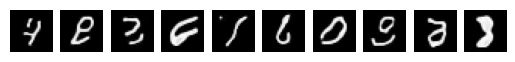

Epoch 31/200: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1517]


Epoch 31 | Avg Loss: 0.1517


Epoch 32/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1534]


Epoch 32 | Avg Loss: 0.1514


Epoch 33/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1552]


Epoch 33 | Avg Loss: 0.1520


Epoch 34/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1504]


Epoch 34 | Avg Loss: 0.1517


Epoch 35/200: 100%|██████████| 47/47 [00:06<00:00,  7.25it/s, Loss=0.1554]


Epoch 35 | Avg Loss: 0.1506


Epoch 36/200: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1572]


Epoch 36 | Avg Loss: 0.1515


Epoch 37/200: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1459]


Epoch 37 | Avg Loss: 0.1510


Epoch 38/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1494]


Epoch 38 | Avg Loss: 0.1516


Epoch 39/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1480]


Epoch 39 | Avg Loss: 0.1507


Epoch 40/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1433]


Epoch 40 | Avg Loss: 0.1495


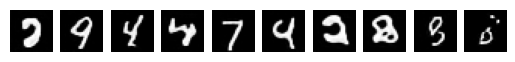

Epoch 41/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1514]


Epoch 41 | Avg Loss: 0.1501


Epoch 42/200: 100%|██████████| 47/47 [00:06<00:00,  7.25it/s, Loss=0.1480]


Epoch 42 | Avg Loss: 0.1504


Epoch 43/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1524]


Epoch 43 | Avg Loss: 0.1504


Epoch 44/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1517]


Epoch 44 | Avg Loss: 0.1498


Epoch 45/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1500]


Epoch 45 | Avg Loss: 0.1509


Epoch 46/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1499]


Epoch 46 | Avg Loss: 0.1502


Epoch 47/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1528]


Epoch 47 | Avg Loss: 0.1502


Epoch 48/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1509]


Epoch 48 | Avg Loss: 0.1500


Epoch 49/200: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1480]


Epoch 49 | Avg Loss: 0.1502


Epoch 50/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1492]


Epoch 50 | Avg Loss: 0.1498


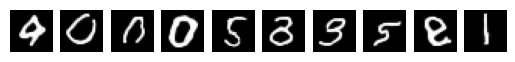

Epoch 51/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1513]


Epoch 51 | Avg Loss: 0.1494


Epoch 52/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1513]


Epoch 52 | Avg Loss: 0.1490


Epoch 53/200: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1514]


Epoch 53 | Avg Loss: 0.1495


Epoch 54/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1432]


Epoch 54 | Avg Loss: 0.1500


Epoch 55/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1527]


Epoch 55 | Avg Loss: 0.1501


Epoch 56/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1550]


Epoch 56 | Avg Loss: 0.1494


Epoch 57/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1433]


Epoch 57 | Avg Loss: 0.1487


Epoch 58/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1479]


Epoch 58 | Avg Loss: 0.1493


Epoch 59/200: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1474]


Epoch 59 | Avg Loss: 0.1495


Epoch 60/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1515]


Epoch 60 | Avg Loss: 0.1498


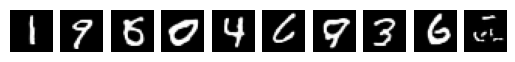

Epoch 61/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1479]


Epoch 61 | Avg Loss: 0.1493


Epoch 62/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1491]


Epoch 62 | Avg Loss: 0.1491


Epoch 63/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1482]


Epoch 63 | Avg Loss: 0.1495


Epoch 64/200: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1468]


Epoch 64 | Avg Loss: 0.1489


Epoch 65/200: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1486]


Epoch 65 | Avg Loss: 0.1483


Epoch 66/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1496]


Epoch 66 | Avg Loss: 0.1491


Epoch 67/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1517]


Epoch 67 | Avg Loss: 0.1498


Epoch 68/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1459]


Epoch 68 | Avg Loss: 0.1491


Epoch 69/200: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1526]


Epoch 69 | Avg Loss: 0.1500


Epoch 70/200: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1453]


Epoch 70 | Avg Loss: 0.1485


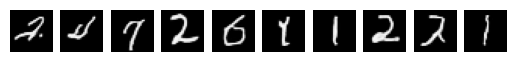

Epoch 71/200: 100%|██████████| 47/47 [00:06<00:00,  7.24it/s, Loss=0.1470]


Epoch 71 | Avg Loss: 0.1494


Epoch 72/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1496]


Epoch 72 | Avg Loss: 0.1489


Epoch 73/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1509]


Epoch 73 | Avg Loss: 0.1493


Epoch 74/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1476]


Epoch 74 | Avg Loss: 0.1485


Epoch 75/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1493]


Epoch 75 | Avg Loss: 0.1482


Epoch 76/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1448]


Epoch 76 | Avg Loss: 0.1486


Epoch 77/200: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1503]


Epoch 77 | Avg Loss: 0.1497


Epoch 78/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1442]


Epoch 78 | Avg Loss: 0.1484


Epoch 79/200: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1466]


Epoch 79 | Avg Loss: 0.1495


Epoch 80/200: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1543]


Epoch 80 | Avg Loss: 0.1486


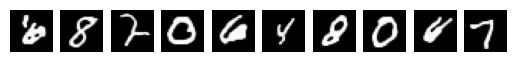

Epoch 81/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1496]


Epoch 81 | Avg Loss: 0.1486


Epoch 82/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1460]


Epoch 82 | Avg Loss: 0.1482


Epoch 83/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1447]


Epoch 83 | Avg Loss: 0.1482


Epoch 84/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1475]


Epoch 84 | Avg Loss: 0.1478


Epoch 85/200: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1533]


Epoch 85 | Avg Loss: 0.1488


Epoch 86/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1497]


Epoch 86 | Avg Loss: 0.1476


Epoch 87/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1524]


Epoch 87 | Avg Loss: 0.1485


Epoch 88/200: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1513]


Epoch 88 | Avg Loss: 0.1486


Epoch 89/200: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1398]


Epoch 89 | Avg Loss: 0.1490


Epoch 90/200: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1451]


Epoch 90 | Avg Loss: 0.1480


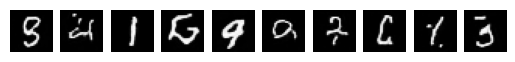

Epoch 91/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1511]


Epoch 91 | Avg Loss: 0.1475


Epoch 92/200: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1498]


Epoch 92 | Avg Loss: 0.1483


Epoch 93/200: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1455]


Epoch 93 | Avg Loss: 0.1473


Epoch 94/200: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1577]


Epoch 94 | Avg Loss: 0.1484


Epoch 95/200: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1513]


Epoch 95 | Avg Loss: 0.1485


Epoch 96/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1462]


Epoch 96 | Avg Loss: 0.1481


Epoch 97/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1470]


Epoch 97 | Avg Loss: 0.1477


Epoch 98/200: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1508]


Epoch 98 | Avg Loss: 0.1480


Epoch 99/200: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1519]


Epoch 99 | Avg Loss: 0.1482


Epoch 100/200: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1482]


Epoch 100 | Avg Loss: 0.1483


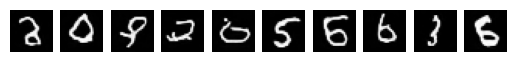

Epoch 101/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1466]


Epoch 101 | Avg Loss: 0.1472


Epoch 102/200: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1460]


Epoch 102 | Avg Loss: 0.1474


Epoch 103/200: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1523]


Epoch 103 | Avg Loss: 0.1474


Epoch 104/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1452]


Epoch 104 | Avg Loss: 0.1466


Epoch 105/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1464]


Epoch 105 | Avg Loss: 0.1476


Epoch 106/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1430]


Epoch 106 | Avg Loss: 0.1476


Epoch 107/200: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1460]


Epoch 107 | Avg Loss: 0.1491


Epoch 108/200: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1472]


Epoch 108 | Avg Loss: 0.1479


Epoch 109/200: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1486]


Epoch 109 | Avg Loss: 0.1478


Epoch 110/200: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1487]


Epoch 110 | Avg Loss: 0.1475


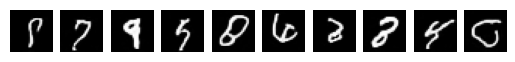

Epoch 111/200: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1510]


Epoch 111 | Avg Loss: 0.1476


Epoch 112/200: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1426]


Epoch 112 | Avg Loss: 0.1473


Epoch 113/200: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1465]


Epoch 113 | Avg Loss: 0.1473


Epoch 114/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1465]


Epoch 114 | Avg Loss: 0.1466


Epoch 115/200: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1512]


Epoch 115 | Avg Loss: 0.1482


Epoch 116/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1513]


Epoch 116 | Avg Loss: 0.1480


Epoch 117/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1479]


Epoch 117 | Avg Loss: 0.1472


Epoch 118/200: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1504]


Epoch 118 | Avg Loss: 0.1483


Epoch 119/200: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1510]


Epoch 119 | Avg Loss: 0.1473


Epoch 120/200: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1480]


Epoch 120 | Avg Loss: 0.1474


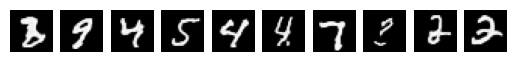

Epoch 121/200: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1445]


Epoch 121 | Avg Loss: 0.1469


Epoch 122/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1411]


Epoch 122 | Avg Loss: 0.1473


Epoch 123/200: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1512]


Epoch 123 | Avg Loss: 0.1472


Epoch 124/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1475]


Epoch 124 | Avg Loss: 0.1476


Epoch 125/200: 100%|██████████| 47/47 [00:06<00:00,  6.91it/s, Loss=0.1470]


Epoch 125 | Avg Loss: 0.1472


Epoch 126/200: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1530]


Epoch 126 | Avg Loss: 0.1471


Epoch 127/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1495]


Epoch 127 | Avg Loss: 0.1474


Epoch 128/200: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1461]


Epoch 128 | Avg Loss: 0.1471


Epoch 129/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1447]


Epoch 129 | Avg Loss: 0.1474


Epoch 130/200: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1529]


Epoch 130 | Avg Loss: 0.1480


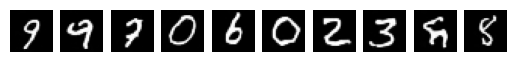

Epoch 131/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1488]


Epoch 131 | Avg Loss: 0.1470


Epoch 132/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1478]


Epoch 132 | Avg Loss: 0.1473


Epoch 133/200: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1458]


Epoch 133 | Avg Loss: 0.1478


Epoch 134/200: 100%|██████████| 47/47 [00:06<00:00,  6.84it/s, Loss=0.1506]


Epoch 134 | Avg Loss: 0.1478


Epoch 135/200: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, Loss=0.1483]


Epoch 135 | Avg Loss: 0.1467


Epoch 136/200: 100%|██████████| 47/47 [00:06<00:00,  6.93it/s, Loss=0.1431]


Epoch 136 | Avg Loss: 0.1468


Epoch 137/200: 100%|██████████| 47/47 [00:06<00:00,  6.88it/s, Loss=0.1513]


Epoch 137 | Avg Loss: 0.1471


Epoch 138/200: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1383]


Epoch 138 | Avg Loss: 0.1467


Epoch 139/200: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1479]


Epoch 139 | Avg Loss: 0.1472


Epoch 140/200: 100%|██████████| 47/47 [00:06<00:00,  6.87it/s, Loss=0.1491]


Epoch 140 | Avg Loss: 0.1466


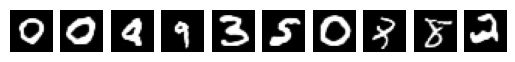

Epoch 141/200: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1492]


Epoch 141 | Avg Loss: 0.1471


Epoch 142/200: 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=0.1409]


Epoch 142 | Avg Loss: 0.1472


Epoch 143/200: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1504]


Epoch 143 | Avg Loss: 0.1472


Epoch 144/200: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1500]


Epoch 144 | Avg Loss: 0.1476


Epoch 145/200: 100%|██████████| 47/47 [00:06<00:00,  6.92it/s, Loss=0.1434]


Epoch 145 | Avg Loss: 0.1470


Epoch 146/200: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, Loss=0.1446]


Epoch 146 | Avg Loss: 0.1475


Epoch 147/200: 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=0.1485]


Epoch 147 | Avg Loss: 0.1470


Epoch 148/200: 100%|██████████| 47/47 [00:06<00:00,  6.89it/s, Loss=0.1419]


Epoch 148 | Avg Loss: 0.1475


Epoch 149/200: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1452]


Epoch 149 | Avg Loss: 0.1471


Epoch 150/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1452]


Epoch 150 | Avg Loss: 0.1463


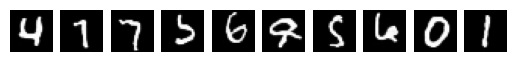

Epoch 151/200: 100%|██████████| 47/47 [00:06<00:00,  6.93it/s, Loss=0.1413]


Epoch 151 | Avg Loss: 0.1458


Epoch 152/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1503]


Epoch 152 | Avg Loss: 0.1464


Epoch 153/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1408]


Epoch 153 | Avg Loss: 0.1461


Epoch 154/200: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1432]


Epoch 154 | Avg Loss: 0.1473


Epoch 155/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1406]


Epoch 155 | Avg Loss: 0.1470


Epoch 156/200: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1448]


Epoch 156 | Avg Loss: 0.1475


Epoch 157/200: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1451]


Epoch 157 | Avg Loss: 0.1464


Epoch 158/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1430]


Epoch 158 | Avg Loss: 0.1474


Epoch 159/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1435]


Epoch 159 | Avg Loss: 0.1476


Epoch 160/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1474]


Epoch 160 | Avg Loss: 0.1473


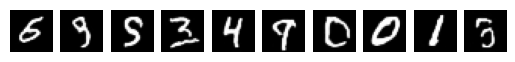

Epoch 161/200: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1516]


Epoch 161 | Avg Loss: 0.1467


Epoch 162/200: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1503]


Epoch 162 | Avg Loss: 0.1465


Epoch 163/200: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1476]


Epoch 163 | Avg Loss: 0.1461


Epoch 164/200: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1493]


Epoch 164 | Avg Loss: 0.1463


Epoch 165/200: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1457]


Epoch 165 | Avg Loss: 0.1473


Epoch 166/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1449]


Epoch 166 | Avg Loss: 0.1465


Epoch 167/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1417]


Epoch 167 | Avg Loss: 0.1464


Epoch 168/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1415]


Epoch 168 | Avg Loss: 0.1469


Epoch 169/200: 100%|██████████| 47/47 [00:06<00:00,  6.94it/s, Loss=0.1434]


Epoch 169 | Avg Loss: 0.1462


Epoch 170/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1420]


Epoch 170 | Avg Loss: 0.1466


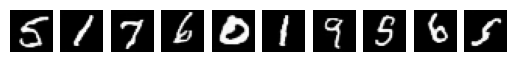

Epoch 171/200: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1470]


Epoch 171 | Avg Loss: 0.1466


Epoch 172/200: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1450]


Epoch 172 | Avg Loss: 0.1463


Epoch 173/200: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1455]


Epoch 173 | Avg Loss: 0.1473


Epoch 174/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1438]


Epoch 174 | Avg Loss: 0.1463


Epoch 175/200: 100%|██████████| 47/47 [00:06<00:00,  6.94it/s, Loss=0.1499]


Epoch 175 | Avg Loss: 0.1477


Epoch 176/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1446]


Epoch 176 | Avg Loss: 0.1470


Epoch 177/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1444]


Epoch 177 | Avg Loss: 0.1469


Epoch 178/200: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1493]


Epoch 178 | Avg Loss: 0.1469


Epoch 179/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1455]


Epoch 179 | Avg Loss: 0.1466


Epoch 180/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1474]


Epoch 180 | Avg Loss: 0.1472


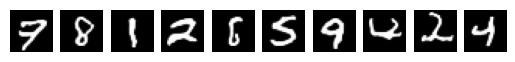

Epoch 181/200: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1438]


Epoch 181 | Avg Loss: 0.1467


Epoch 182/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1456]


Epoch 182 | Avg Loss: 0.1466


Epoch 183/200: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1477]


Epoch 183 | Avg Loss: 0.1458


Epoch 184/200: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1406]


Epoch 184 | Avg Loss: 0.1465


Epoch 185/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1481]


Epoch 185 | Avg Loss: 0.1469


Epoch 186/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1418]


Epoch 186 | Avg Loss: 0.1463


Epoch 187/200: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1439]


Epoch 187 | Avg Loss: 0.1466


Epoch 188/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1427]


Epoch 188 | Avg Loss: 0.1468


Epoch 189/200: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1481]


Epoch 189 | Avg Loss: 0.1463


Epoch 190/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1446]


Epoch 190 | Avg Loss: 0.1465


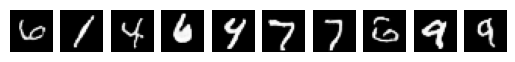

Epoch 191/200: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, Loss=0.1425]


Epoch 191 | Avg Loss: 0.1472


Epoch 192/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1476]


Epoch 192 | Avg Loss: 0.1459


Epoch 193/200: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1476]


Epoch 193 | Avg Loss: 0.1460


Epoch 194/200: 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=0.1441]


Epoch 194 | Avg Loss: 0.1464


Epoch 195/200: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1473]


Epoch 195 | Avg Loss: 0.1468


Epoch 196/200: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1468]


Epoch 196 | Avg Loss: 0.1470


Epoch 197/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1415]


Epoch 197 | Avg Loss: 0.1463


Epoch 198/200: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1487]


Epoch 198 | Avg Loss: 0.1468


Epoch 199/200: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1451]


Epoch 199 | Avg Loss: 0.1465


Epoch 200/200: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1466]


Epoch 200 | Avg Loss: 0.1460


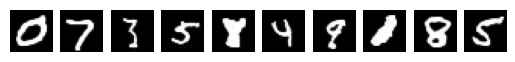

Training completed!


In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
sample = True
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+1:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")

Epoch 201/401: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1489]


Epoch 1 | Avg Loss: 0.1473


Epoch 202/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1453]


Epoch 2 | Avg Loss: 0.1464


Epoch 203/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1424]


Epoch 3 | Avg Loss: 0.1467


Epoch 204/401: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1464]


Epoch 4 | Avg Loss: 0.1474


Epoch 205/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1508]


Epoch 5 | Avg Loss: 0.1459


Epoch 206/401: 100%|██████████| 47/47 [00:06<00:00,  6.87it/s, Loss=0.1533]


Epoch 6 | Avg Loss: 0.1454


Epoch 207/401: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1502]


Epoch 7 | Avg Loss: 0.1471


Epoch 208/401: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1440]


Epoch 8 | Avg Loss: 0.1465


Epoch 209/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1454]


Epoch 9 | Avg Loss: 0.1472


Epoch 210/401: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1454]


Epoch 10 | Avg Loss: 0.1461


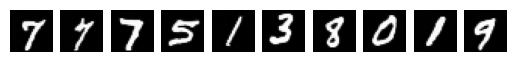

Epoch 211/401: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1494]


Epoch 11 | Avg Loss: 0.1462


Epoch 212/401: 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=0.1513]


Epoch 12 | Avg Loss: 0.1466


Epoch 213/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1486]


Epoch 13 | Avg Loss: 0.1463


Epoch 214/401: 100%|██████████| 47/47 [00:06<00:00,  6.92it/s, Loss=0.1424]


Epoch 14 | Avg Loss: 0.1464


Epoch 215/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1455]


Epoch 15 | Avg Loss: 0.1460


Epoch 216/401: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1504]


Epoch 16 | Avg Loss: 0.1470


Epoch 217/401: 100%|██████████| 47/47 [00:06<00:00,  6.94it/s, Loss=0.1463]


Epoch 17 | Avg Loss: 0.1468


Epoch 218/401: 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=0.1462]


Epoch 18 | Avg Loss: 0.1465


Epoch 219/401: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1429]


Epoch 19 | Avg Loss: 0.1458


Epoch 220/401: 100%|██████████| 47/47 [00:06<00:00,  6.93it/s, Loss=0.1487]


Epoch 20 | Avg Loss: 0.1467


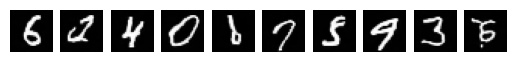

Epoch 221/401: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1444]


Epoch 21 | Avg Loss: 0.1462


Epoch 222/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1473]


Epoch 22 | Avg Loss: 0.1469


Epoch 223/401: 100%|██████████| 47/47 [00:06<00:00,  6.91it/s, Loss=0.1434]


Epoch 23 | Avg Loss: 0.1462


Epoch 224/401: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1503]


Epoch 24 | Avg Loss: 0.1455


Epoch 225/401: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1487]


Epoch 25 | Avg Loss: 0.1462


Epoch 226/401: 100%|██████████| 47/47 [00:06<00:00,  6.89it/s, Loss=0.1561]


Epoch 26 | Avg Loss: 0.1465


Epoch 227/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1436]


Epoch 27 | Avg Loss: 0.1464


Epoch 228/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1438]


Epoch 28 | Avg Loss: 0.1473


Epoch 229/401: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, Loss=0.1490]


Epoch 29 | Avg Loss: 0.1467


Epoch 230/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1511]


Epoch 30 | Avg Loss: 0.1457


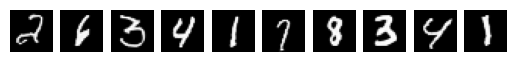

Epoch 231/401: 100%|██████████| 47/47 [00:06<00:00,  6.92it/s, Loss=0.1450]


Epoch 31 | Avg Loss: 0.1470


Epoch 232/401: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1461]


Epoch 32 | Avg Loss: 0.1459


Epoch 233/401: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1465]


Epoch 33 | Avg Loss: 0.1462


Epoch 234/401: 100%|██████████| 47/47 [00:06<00:00,  6.93it/s, Loss=0.1486]


Epoch 34 | Avg Loss: 0.1470


Epoch 235/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1465]


Epoch 35 | Avg Loss: 0.1465


Epoch 236/401: 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=0.1504]


Epoch 36 | Avg Loss: 0.1454


Epoch 237/401: 100%|██████████| 47/47 [00:06<00:00,  6.87it/s, Loss=0.1492]


Epoch 37 | Avg Loss: 0.1463


Epoch 238/401: 100%|██████████| 47/47 [00:06<00:00,  6.93it/s, Loss=0.1418]


Epoch 38 | Avg Loss: 0.1459


Epoch 239/401: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, Loss=0.1431]


Epoch 39 | Avg Loss: 0.1469


Epoch 240/401: 100%|██████████| 47/47 [00:06<00:00,  6.88it/s, Loss=0.1485]


Epoch 40 | Avg Loss: 0.1456


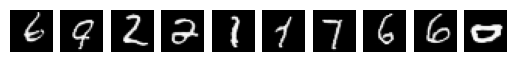

Epoch 241/401: 100%|██████████| 47/47 [00:06<00:00,  6.98it/s, Loss=0.1454]


Epoch 41 | Avg Loss: 0.1458


Epoch 242/401: 100%|██████████| 47/47 [00:06<00:00,  6.89it/s, Loss=0.1449]


Epoch 42 | Avg Loss: 0.1458


Epoch 243/401: 100%|██████████| 47/47 [00:06<00:00,  6.93it/s, Loss=0.1546]


Epoch 43 | Avg Loss: 0.1463


Epoch 244/401: 100%|██████████| 47/47 [00:06<00:00,  6.94it/s, Loss=0.1446]


Epoch 44 | Avg Loss: 0.1456


Epoch 245/401: 100%|██████████| 47/47 [00:06<00:00,  6.86it/s, Loss=0.1438]


Epoch 45 | Avg Loss: 0.1467


Epoch 246/401: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1503]


Epoch 46 | Avg Loss: 0.1462


Epoch 247/401: 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=0.1444]


Epoch 47 | Avg Loss: 0.1458


Epoch 248/401: 100%|██████████| 47/47 [00:06<00:00,  6.89it/s, Loss=0.1464]


Epoch 48 | Avg Loss: 0.1463


Epoch 249/401: 100%|██████████| 47/47 [00:06<00:00,  6.97it/s, Loss=0.1532]


Epoch 49 | Avg Loss: 0.1459


Epoch 250/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1521]


Epoch 50 | Avg Loss: 0.1461


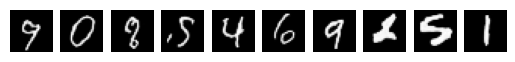

Epoch 251/401: 100%|██████████| 47/47 [00:06<00:00,  6.90it/s, Loss=0.1477]


Epoch 51 | Avg Loss: 0.1464


Epoch 252/401: 100%|██████████| 47/47 [00:06<00:00,  6.92it/s, Loss=0.1410]


Epoch 52 | Avg Loss: 0.1460


Epoch 253/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1470]


Epoch 53 | Avg Loss: 0.1460


Epoch 254/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1533]


Epoch 54 | Avg Loss: 0.1460


Epoch 255/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1449]


Epoch 55 | Avg Loss: 0.1453


Epoch 256/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1473]


Epoch 56 | Avg Loss: 0.1464


Epoch 257/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1522]


Epoch 57 | Avg Loss: 0.1459


Epoch 258/401: 100%|██████████| 47/47 [00:06<00:00,  6.92it/s, Loss=0.1491]


Epoch 58 | Avg Loss: 0.1466


Epoch 259/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1470]


Epoch 59 | Avg Loss: 0.1456


Epoch 260/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1486]


Epoch 60 | Avg Loss: 0.1465


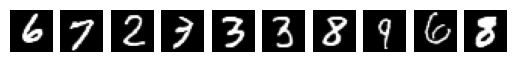

Epoch 261/401: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1408]


Epoch 61 | Avg Loss: 0.1470


Epoch 262/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1468]


Epoch 62 | Avg Loss: 0.1464


Epoch 263/401: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, Loss=0.1499]


Epoch 63 | Avg Loss: 0.1460


Epoch 264/401: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1505]


Epoch 64 | Avg Loss: 0.1456


Epoch 265/401: 100%|██████████| 47/47 [00:06<00:00,  6.99it/s, Loss=0.1428]


Epoch 65 | Avg Loss: 0.1454


Epoch 266/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1457]


Epoch 66 | Avg Loss: 0.1459


Epoch 267/401: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1485]


Epoch 67 | Avg Loss: 0.1448


Epoch 268/401: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1497]


Epoch 68 | Avg Loss: 0.1462


Epoch 269/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1522]


Epoch 69 | Avg Loss: 0.1467


Epoch 270/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1430]


Epoch 70 | Avg Loss: 0.1459


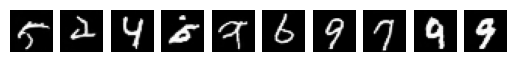

Epoch 271/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1366]


Epoch 71 | Avg Loss: 0.1457


Epoch 272/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1488]


Epoch 72 | Avg Loss: 0.1460


Epoch 273/401: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1419]


Epoch 73 | Avg Loss: 0.1456


Epoch 274/401: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1446]


Epoch 74 | Avg Loss: 0.1457


Epoch 275/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1501]


Epoch 75 | Avg Loss: 0.1462


Epoch 276/401: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1446]


Epoch 76 | Avg Loss: 0.1464


Epoch 277/401: 100%|██████████| 47/47 [00:06<00:00,  7.23it/s, Loss=0.1403]


Epoch 77 | Avg Loss: 0.1456


Epoch 278/401: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1434]


Epoch 78 | Avg Loss: 0.1457


Epoch 279/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1487]


Epoch 79 | Avg Loss: 0.1467


Epoch 280/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1494]


Epoch 80 | Avg Loss: 0.1462


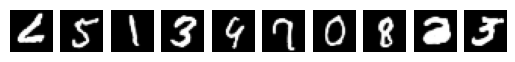

Epoch 281/401: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1536]


Epoch 81 | Avg Loss: 0.1455


Epoch 282/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1421]


Epoch 82 | Avg Loss: 0.1459


Epoch 283/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1439]


Epoch 83 | Avg Loss: 0.1459


Epoch 284/401: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1412]


Epoch 84 | Avg Loss: 0.1455


Epoch 285/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1393]


Epoch 85 | Avg Loss: 0.1453


Epoch 286/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1415]


Epoch 86 | Avg Loss: 0.1462


Epoch 287/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1430]


Epoch 87 | Avg Loss: 0.1452


Epoch 288/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1538]


Epoch 88 | Avg Loss: 0.1455


Epoch 289/401: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1423]


Epoch 89 | Avg Loss: 0.1462


Epoch 290/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1458]


Epoch 90 | Avg Loss: 0.1460


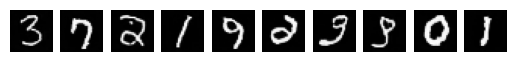

Epoch 291/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1517]


Epoch 91 | Avg Loss: 0.1467


Epoch 292/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1410]


Epoch 92 | Avg Loss: 0.1453


Epoch 293/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1436]


Epoch 93 | Avg Loss: 0.1460


Epoch 294/401: 100%|██████████| 47/47 [00:06<00:00,  7.21it/s, Loss=0.1400]


Epoch 94 | Avg Loss: 0.1458


Epoch 295/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1393]


Epoch 95 | Avg Loss: 0.1462


Epoch 296/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1485]


Epoch 96 | Avg Loss: 0.1458


Epoch 297/401: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1485]


Epoch 97 | Avg Loss: 0.1458


Epoch 298/401: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1422]


Epoch 98 | Avg Loss: 0.1461


Epoch 299/401: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1528]


Epoch 99 | Avg Loss: 0.1456


Epoch 300/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1456]


Epoch 100 | Avg Loss: 0.1459


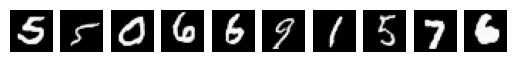

Epoch 301/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1475]


Epoch 101 | Avg Loss: 0.1458


Epoch 302/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1435]


Epoch 102 | Avg Loss: 0.1459


Epoch 303/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1447]


Epoch 103 | Avg Loss: 0.1460


Epoch 304/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1454]


Epoch 104 | Avg Loss: 0.1451


Epoch 305/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1457]


Epoch 105 | Avg Loss: 0.1451


Epoch 306/401: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1414]


Epoch 106 | Avg Loss: 0.1461


Epoch 307/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1530]


Epoch 107 | Avg Loss: 0.1459


Epoch 308/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1404]


Epoch 108 | Avg Loss: 0.1455


Epoch 309/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1493]


Epoch 109 | Avg Loss: 0.1460


Epoch 310/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1420]


Epoch 110 | Avg Loss: 0.1457


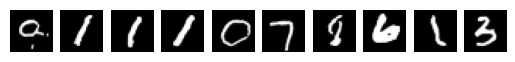

Epoch 311/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1464]


Epoch 111 | Avg Loss: 0.1465


Epoch 312/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1513]


Epoch 112 | Avg Loss: 0.1458


Epoch 313/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1449]


Epoch 113 | Avg Loss: 0.1459


Epoch 314/401: 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=0.1512]


Epoch 114 | Avg Loss: 0.1460


Epoch 315/401: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1510]


Epoch 115 | Avg Loss: 0.1454


Epoch 316/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1482]


Epoch 116 | Avg Loss: 0.1451


Epoch 317/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1517]


Epoch 117 | Avg Loss: 0.1460


Epoch 318/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1448]


Epoch 118 | Avg Loss: 0.1460


Epoch 319/401: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1471]


Epoch 119 | Avg Loss: 0.1463


Epoch 320/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1461]


Epoch 120 | Avg Loss: 0.1460


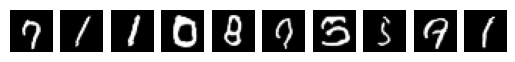

Epoch 321/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1473]


Epoch 121 | Avg Loss: 0.1449


Epoch 322/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1446]


Epoch 122 | Avg Loss: 0.1458


Epoch 323/401: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1437]


Epoch 123 | Avg Loss: 0.1453


Epoch 324/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1455]


Epoch 124 | Avg Loss: 0.1459


Epoch 325/401: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1458]


Epoch 125 | Avg Loss: 0.1456


Epoch 326/401: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1470]


Epoch 126 | Avg Loss: 0.1460


Epoch 327/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1453]


Epoch 127 | Avg Loss: 0.1458


Epoch 328/401: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1427]


Epoch 128 | Avg Loss: 0.1464


Epoch 329/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1502]


Epoch 129 | Avg Loss: 0.1458


Epoch 330/401: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1491]


Epoch 130 | Avg Loss: 0.1447


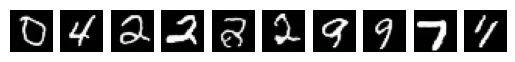

Epoch 331/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1458]


Epoch 131 | Avg Loss: 0.1460


Epoch 332/401: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1470]


Epoch 132 | Avg Loss: 0.1455


Epoch 333/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1395]


Epoch 133 | Avg Loss: 0.1454


Epoch 334/401: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1408]


Epoch 134 | Avg Loss: 0.1456


Epoch 335/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1475]


Epoch 135 | Avg Loss: 0.1461


Epoch 336/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1478]


Epoch 136 | Avg Loss: 0.1459


Epoch 337/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1519]


Epoch 137 | Avg Loss: 0.1461


Epoch 338/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1443]


Epoch 138 | Avg Loss: 0.1462


Epoch 339/401: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1465]


Epoch 139 | Avg Loss: 0.1457


Epoch 340/401: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1522]


Epoch 140 | Avg Loss: 0.1460


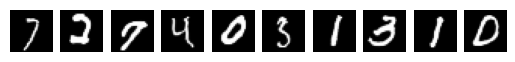

Epoch 341/401: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1404]


Epoch 141 | Avg Loss: 0.1461


Epoch 342/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1473]


Epoch 142 | Avg Loss: 0.1452


Epoch 343/401: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1495]


Epoch 143 | Avg Loss: 0.1465


Epoch 344/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1469]


Epoch 144 | Avg Loss: 0.1454


Epoch 345/401: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1443]


Epoch 145 | Avg Loss: 0.1457


Epoch 346/401: 100%|██████████| 47/47 [00:06<00:00,  7.03it/s, Loss=0.1445]


Epoch 146 | Avg Loss: 0.1463


Epoch 347/401: 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=0.1468]


Epoch 147 | Avg Loss: 0.1452


Epoch 348/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1437]


Epoch 148 | Avg Loss: 0.1455


Epoch 349/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1429]


Epoch 149 | Avg Loss: 0.1455


Epoch 350/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1479]


Epoch 150 | Avg Loss: 0.1462


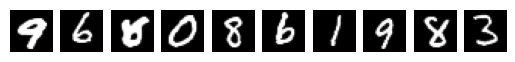

Epoch 351/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1416]


Epoch 151 | Avg Loss: 0.1462


Epoch 352/401: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1486]


Epoch 152 | Avg Loss: 0.1459


Epoch 353/401: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, Loss=0.1481]


Epoch 153 | Avg Loss: 0.1452


Epoch 354/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1388]


Epoch 154 | Avg Loss: 0.1455


Epoch 355/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1427]


Epoch 155 | Avg Loss: 0.1461


Epoch 356/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1480]


Epoch 156 | Avg Loss: 0.1447


Epoch 357/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1438]


Epoch 157 | Avg Loss: 0.1449


Epoch 358/401: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1420]


Epoch 158 | Avg Loss: 0.1456


Epoch 359/401: 100%|██████████| 47/47 [00:06<00:00,  7.24it/s, Loss=0.1473]


Epoch 159 | Avg Loss: 0.1451


Epoch 360/401: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s, Loss=0.1473]


Epoch 160 | Avg Loss: 0.1461


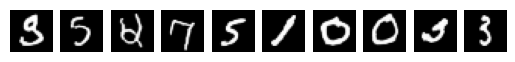

Epoch 361/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1482]


Epoch 161 | Avg Loss: 0.1464


Epoch 362/401: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1482]


Epoch 162 | Avg Loss: 0.1458


Epoch 363/401: 100%|██████████| 47/47 [00:06<00:00,  7.16it/s, Loss=0.1528]


Epoch 163 | Avg Loss: 0.1450


Epoch 364/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1479]


Epoch 164 | Avg Loss: 0.1458


Epoch 365/401: 100%|██████████| 47/47 [00:06<00:00,  7.20it/s, Loss=0.1450]


Epoch 165 | Avg Loss: 0.1454


Epoch 366/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1470]


Epoch 166 | Avg Loss: 0.1459


Epoch 367/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1451]


Epoch 167 | Avg Loss: 0.1450


Epoch 368/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1446]


Epoch 168 | Avg Loss: 0.1454


Epoch 369/401: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1467]


Epoch 169 | Avg Loss: 0.1447


Epoch 370/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1455]


Epoch 170 | Avg Loss: 0.1458


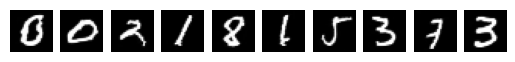

Epoch 371/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1497]


Epoch 171 | Avg Loss: 0.1461


Epoch 372/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1479]


Epoch 172 | Avg Loss: 0.1460


Epoch 373/401: 100%|██████████| 47/47 [00:06<00:00,  7.09it/s, Loss=0.1483]


Epoch 173 | Avg Loss: 0.1458


Epoch 374/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1415]


Epoch 174 | Avg Loss: 0.1456


Epoch 375/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1471]


Epoch 175 | Avg Loss: 0.1451


Epoch 376/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1464]


Epoch 176 | Avg Loss: 0.1459


Epoch 377/401: 100%|██████████| 47/47 [00:06<00:00,  7.14it/s, Loss=0.1511]


Epoch 177 | Avg Loss: 0.1454


Epoch 378/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1434]


Epoch 178 | Avg Loss: 0.1450


Epoch 379/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1427]


Epoch 179 | Avg Loss: 0.1459


Epoch 380/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1433]


Epoch 180 | Avg Loss: 0.1461


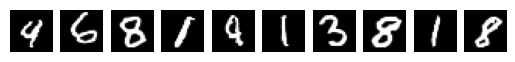

Epoch 381/401: 100%|██████████| 47/47 [00:06<00:00,  7.00it/s, Loss=0.1482]


Epoch 181 | Avg Loss: 0.1458


Epoch 382/401: 100%|██████████| 47/47 [00:06<00:00,  7.07it/s, Loss=0.1435]


Epoch 182 | Avg Loss: 0.1451


Epoch 383/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1491]


Epoch 183 | Avg Loss: 0.1454


Epoch 384/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1498]


Epoch 184 | Avg Loss: 0.1460


Epoch 385/401: 100%|██████████| 47/47 [00:06<00:00,  7.12it/s, Loss=0.1494]


Epoch 185 | Avg Loss: 0.1449


Epoch 386/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1460]


Epoch 186 | Avg Loss: 0.1462


Epoch 387/401: 100%|██████████| 47/47 [00:06<00:00,  7.05it/s, Loss=0.1400]


Epoch 187 | Avg Loss: 0.1449


Epoch 388/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1429]


Epoch 188 | Avg Loss: 0.1461


Epoch 389/401: 100%|██████████| 47/47 [00:06<00:00,  7.08it/s, Loss=0.1456]


Epoch 189 | Avg Loss: 0.1462


Epoch 390/401: 100%|██████████| 47/47 [00:06<00:00,  7.17it/s, Loss=0.1466]


Epoch 190 | Avg Loss: 0.1446


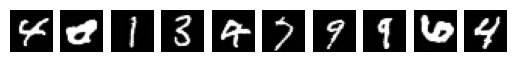

Epoch 391/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1517]


Epoch 191 | Avg Loss: 0.1455


Epoch 392/401: 100%|██████████| 47/47 [00:06<00:00,  7.18it/s, Loss=0.1464]


Epoch 192 | Avg Loss: 0.1453


Epoch 393/401: 100%|██████████| 47/47 [00:06<00:00,  7.19it/s, Loss=0.1422]


Epoch 193 | Avg Loss: 0.1458


Epoch 394/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1477]


Epoch 194 | Avg Loss: 0.1460


Epoch 395/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1507]


Epoch 195 | Avg Loss: 0.1459


Epoch 396/401: 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=0.1452]


Epoch 196 | Avg Loss: 0.1453


Epoch 397/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1494]


Epoch 197 | Avg Loss: 0.1448


Epoch 398/401: 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=0.1432]


Epoch 198 | Avg Loss: 0.1456


Epoch 399/401: 100%|██████████| 47/47 [00:06<00:00,  7.01it/s, Loss=0.1474]


Epoch 199 | Avg Loss: 0.1452


Epoch 400/401: 100%|██████████| 47/47 [00:06<00:00,  7.11it/s, Loss=0.1475]


Epoch 200 | Avg Loss: 0.1460


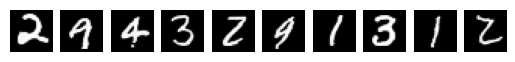

Training completed!


In [9]:
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
sample = True
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+201}/{config['epochs']+201}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+201:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")

In [10]:
print(best_loss)

0.1445668913582538
